<a href="https://colab.research.google.com/github/jhonnybenna/machine_learning/blob/main/Spaceship_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Machine Learning and Data Mining Project: Spaceship Titanic
In this Colab Notebook we will use Machine Learning techniques to solve the Kaggle competions "Spaceship Titanic".



#Importing Dependencies


In [1]:
URL = "https://raw.githubusercontent.com/jhonnybenna/machine_learning/main/"
OUTPUT_PATH = "kaggle_submissions/"
RANDOM_STATE = 42
TRAIN_SIZE = 0.8

DROPCOLUMNS=["PassengerId","Name","Transported"]

#Insert here the description of your test in order to submit to Kaggle
Description="Submission for the kaggle competition Spaceship Titanic "

In [2]:
import os
import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    KFold,
    StratifiedKFold,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from typing import List

import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, f1_score, log_loss
from sklearn.metrics import confusion_matrix, accuracy_score
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier

In [3]:
# For plotting purposes

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#Importing Dataset from GitHub

In [4]:
train = pd.read_csv(URL + "train.csv")
test = pd.read_csv(URL + "test.csv")

In [5]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [6]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


#Data Inspection

In [7]:
train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

As we can see, the dataset contains both numerical data and non-numerical data (object).

Our goal is to predict the value of `Transported` based on the other features.

But, before training the model, let's make sure all of the data is in a proper format.

Since the `Cabin` columns contain data written in the format: `Deck`/`Cabin_num`/`Side`; it is necessary to split it into three different columns, each containing only one of the three variables

In [8]:
train[["Deck", "Cabin_num", "Side"]] = train["Cabin"].str.split("/", expand=True)
# Dropping the column Cabin after splitting it into three separate columns
train.drop('Cabin', axis='columns', inplace=True)

In [9]:
test[["Deck", "Cabin_num", "Side"]] = test["Cabin"].str.split("/", expand=True)
# Dropping the column Cabin after splitting it into three separate columns
test.drop('Cabin', axis='columns', inplace=True)

In [10]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Cabin_num,Side
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0,P
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,S
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0,S
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0,S
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1,S


In [11]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Deck,Cabin_num,Side
0,0013_01,Earth,True,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,G,3,S
1,0018_01,Earth,False,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,F,4,S
2,0019_01,Europa,True,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,C,0,S
3,0021_01,Europa,False,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,C,1,S
4,0023_01,Earth,False,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,F,5,S


## Ordinal Encoding

Before using Ordinal Encoding:

In [12]:
train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
Deck             object
Cabin_num        object
Side             object
dtype: object

In [13]:
ord_enc = OrdinalEncoder()
train_code = train.copy()

for col in train_code.select_dtypes(include=['object', 'bool']).columns:
    train_code[col] = ord_enc.fit_transform(train_code[[col]])

train_code.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Cabin_num,Side
0,0.0,1.0,0.0,2.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,5252.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,2.0,24.0,0.0,109.0,9.0,25.0,549.0,44.0,4502.0,1.0,5.0,0.0,1.0
2,2.0,1.0,0.0,2.0,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,457.0,0.0,0.0,0.0,1.0
3,3.0,1.0,0.0,2.0,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,7149.0,0.0,0.0,0.0,1.0
4,4.0,0.0,0.0,2.0,16.0,0.0,303.0,70.0,151.0,565.0,2.0,8319.0,1.0,5.0,1.0,1.0


After using Ordinal Encoding:

In [14]:
train_code.dtypes

PassengerId     float64
HomePlanet      float64
CryoSleep       float64
Destination     float64
Age             float64
VIP             float64
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name            float64
Transported     float64
Deck            float64
Cabin_num       float64
Side            float64
dtype: object

##Dealing with Missing Values


In [15]:
# counts not_NA values of a DataFrame
def count_missing(df: pd.DataFrame):
    number_of_missing_in_cols = df.shape[0] - df.count()
    return number_of_missing_in_cols.sort_values()

In [16]:
count_missing(train)

PassengerId       0
Transported       0
Age             179
RoomService     181
Destination     182
FoodCourt       183
Spa             183
VRDeck          188
Deck            199
Cabin_num       199
Side            199
Name            200
HomePlanet      201
VIP             203
ShoppingMall    208
CryoSleep       217
dtype: int64

As we can see from the previous line of code, there are many missing values in each column except, obviously, the `Transported` (target) and `PassengerID` ones.

This does not constitute a problem, as tensorflow is able to deal with missing values.

In [17]:
# Count the number of unique values in dataframe
cols_unique_vals_count = train.drop(columns=DROPCOLUMNS).nunique().sort_values()
cols_unique_vals_count

CryoSleep          2
VIP                2
Side               2
HomePlanet         3
Destination        3
Deck               8
Age               80
ShoppingMall    1115
RoomService     1273
VRDeck          1306
Spa             1327
FoodCourt       1507
Cabin_num       1817
dtype: int64

In [18]:
# If the column has only 2 unique values it is a binary col
BINARY_COLS = [col for col, val in cols_unique_vals_count.items() if val == 2]
BINARY_COLS

['CryoSleep', 'VIP', 'Side']

N.B: The `Transported` column has been dropped even though it's a binary column, as we assume it isn't missing any value; therefore we do not need to deal with it.

In [19]:
# Maximum number of unique values which represent a Nominal (categorical) feature
NOMINAL_NUNIQUE_THRESHOLD = 10
NOMINAL_COLS = [
    col
    for col, val in cols_unique_vals_count.items()
    if val > 2 and val < NOMINAL_NUNIQUE_THRESHOLD
]
NOMINAL_COLS

['HomePlanet', 'Destination', 'Deck']

In [20]:
# Maximum number of unique values which represent a Numerical (continuous) feature
NUMERICAL_COLS = [
    col
    for col, val in cols_unique_vals_count.items()
    if val > NOMINAL_NUNIQUE_THRESHOLD
]
NUMERICAL_COLS

['Age',
 'ShoppingMall',
 'RoomService',
 'VRDeck',
 'Spa',
 'FoodCourt',
 'Cabin_num']

In [21]:
COLS = list(np.concatenate((BINARY_COLS, NOMINAL_COLS, NUMERICAL_COLS)))
COLS

['CryoSleep',
 'VIP',
 'Side',
 'HomePlanet',
 'Destination',
 'Deck',
 'Age',
 'ShoppingMall',
 'RoomService',
 'VRDeck',
 'Spa',
 'FoodCourt',
 'Cabin_num']

## Impute Missing Values

### Simple Imputation

In [22]:
def array_to_dataframe(arr: np.ndarray, columns: List[str]):
    return pd.DataFrame(data=arr, columns=columns)

#### Constant

In [23]:
constant_imp_arr = SimpleImputer(strategy="constant").fit_transform(train_code)
constant_imp_df = array_to_dataframe(arr=constant_imp_arr, columns=train_code.columns)
constant_imp_df

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Cabin_num,Side
0,0.0,1.0,0.0,2.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,5252.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,2.0,24.0,0.0,109.0,9.0,25.0,549.0,44.0,4502.0,1.0,5.0,0.0,1.0
2,2.0,1.0,0.0,2.0,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,457.0,0.0,0.0,0.0,1.0
3,3.0,1.0,0.0,2.0,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,7149.0,0.0,0.0,0.0,1.0
4,4.0,0.0,0.0,2.0,16.0,0.0,303.0,70.0,151.0,565.0,2.0,8319.0,1.0,5.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,8688.0,1.0,0.0,0.0,41.0,1.0,0.0,6819.0,0.0,1643.0,74.0,3524.0,0.0,0.0,1795.0,0.0
8689,8689.0,0.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,4780.0,0.0,6.0,548.0,1.0
8690,8690.0,0.0,0.0,2.0,26.0,0.0,0.0,0.0,1872.0,1.0,0.0,3002.0,1.0,6.0,551.0,1.0
8691,8691.0,1.0,0.0,0.0,32.0,0.0,0.0,1049.0,0.0,353.0,3235.0,1596.0,0.0,4.0,1385.0,1.0


In [24]:
count_missing(constant_imp_df)

PassengerId     0
HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
Deck            0
Cabin_num       0
Side            0
dtype: int64

#### Median

In [25]:
median_imp_arr = SimpleImputer(strategy="median").fit_transform(train_code)
median_imp_df = array_to_dataframe(arr=median_imp_arr, columns=train_code.columns)
median_imp_df

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Cabin_num,Side
0,0.0,1.0,0.0,2.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,5252.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,2.0,24.0,0.0,109.0,9.0,25.0,549.0,44.0,4502.0,1.0,5.0,0.0,1.0
2,2.0,1.0,0.0,2.0,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,457.0,0.0,0.0,0.0,1.0
3,3.0,1.0,0.0,2.0,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,7149.0,0.0,0.0,0.0,1.0
4,4.0,0.0,0.0,2.0,16.0,0.0,303.0,70.0,151.0,565.0,2.0,8319.0,1.0,5.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,8688.0,1.0,0.0,0.0,41.0,1.0,0.0,6819.0,0.0,1643.0,74.0,3524.0,0.0,0.0,1795.0,0.0
8689,8689.0,0.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,4780.0,0.0,6.0,548.0,1.0
8690,8690.0,0.0,0.0,2.0,26.0,0.0,0.0,0.0,1872.0,1.0,0.0,3002.0,1.0,6.0,551.0,1.0
8691,8691.0,1.0,0.0,0.0,32.0,0.0,0.0,1049.0,0.0,353.0,3235.0,1596.0,0.0,4.0,1385.0,1.0


In [26]:
count_missing(median_imp_df)

PassengerId     0
HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
Deck            0
Cabin_num       0
Side            0
dtype: int64

### kNN Imputation

In [27]:
knn_imp_arr = KNNImputer().fit_transform(train_code)
knn_imp_df = array_to_dataframe(arr=knn_imp_arr, columns=train_code.columns)
knn_imp_df

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Cabin_num,Side
0,0.0,1.0,0.0,2.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,5252.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,2.0,24.0,0.0,109.0,9.0,25.0,549.0,44.0,4502.0,1.0,5.0,0.0,1.0
2,2.0,1.0,0.0,2.0,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,457.0,0.0,0.0,0.0,1.0
3,3.0,1.0,0.0,2.0,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,7149.0,0.0,0.0,0.0,1.0
4,4.0,0.0,0.0,2.0,16.0,0.0,303.0,70.0,151.0,565.0,2.0,8319.0,1.0,5.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,8688.0,1.0,0.0,0.0,41.0,1.0,0.0,6819.0,0.0,1643.0,74.0,3524.0,0.0,0.0,1795.0,0.0
8689,8689.0,0.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,4780.0,0.0,6.0,548.0,1.0
8690,8690.0,0.0,0.0,2.0,26.0,0.0,0.0,0.0,1872.0,1.0,0.0,3002.0,1.0,6.0,551.0,1.0
8691,8691.0,1.0,0.0,0.0,32.0,0.0,0.0,1049.0,0.0,353.0,3235.0,1596.0,0.0,4.0,1385.0,1.0


In [28]:
count_missing(knn_imp_df)

PassengerId     0
HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
Deck            0
Cabin_num       0
Side            0
dtype: int64

### Model based Imputation

#### IterativeImputer

In [29]:
iter_imp_arr = IterativeImputer().fit_transform(train_code)
iter_imp_df = array_to_dataframe(arr=iter_imp_arr, columns=train_code.columns)
iter_imp_df

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Cabin_num,Side
0,0.0,1.0,0.0,2.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,5252.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,2.0,24.0,0.0,109.0,9.0,25.0,549.0,44.0,4502.0,1.0,5.0,0.0,1.0
2,2.0,1.0,0.0,2.0,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,457.0,0.0,0.0,0.0,1.0
3,3.0,1.0,0.0,2.0,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,7149.0,0.0,0.0,0.0,1.0
4,4.0,0.0,0.0,2.0,16.0,0.0,303.0,70.0,151.0,565.0,2.0,8319.0,1.0,5.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,8688.0,1.0,0.0,0.0,41.0,1.0,0.0,6819.0,0.0,1643.0,74.0,3524.0,0.0,0.0,1795.0,0.0
8689,8689.0,0.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,4780.0,0.0,6.0,548.0,1.0
8690,8690.0,0.0,0.0,2.0,26.0,0.0,0.0,0.0,1872.0,1.0,0.0,3002.0,1.0,6.0,551.0,1.0
8691,8691.0,1.0,0.0,0.0,32.0,0.0,0.0,1049.0,0.0,353.0,3235.0,1596.0,0.0,4.0,1385.0,1.0


In [30]:
count_missing(iter_imp_df)

PassengerId     0
HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
Deck            0
Cabin_num       0
Side            0
dtype: int64

# Model Training

In [31]:
def cmatrix(y_true: pd.DataFrame, y_pred: pd.DataFrame):
    data = confusion_matrix(y_true, y_pred)
    cmatrix_df = pd.DataFrame(
        data, columns=np.unique(y_pred), index=np.unique(y_true)
    )
    cmatrix_df.index.name = 'Actual'
    cmatrix_df.columns.name = 'Predicted'

    plt.figure(figsize=(6,5))

    # set label size
    sns.set(font_scale=1.2)
    # set font size
    axs = sns.heatmap(
        cmatrix_df, cmap="Blues", annot=True, fmt='', annot_kws={"size": 16}
    )
    axs.xaxis.tick_bottom()
    axs.yaxis.tick_left()

def transported_cm(y_true: pd.DataFrame, y_pred: pd.DataFrame):
    cmatrix(y_true, y_pred)
    plt.title("Transported passengers\n")

In [32]:
ts_df = iter_imp_df

X = ts_df.drop(DROPCOLUMNS, axis='columns')
y = ts_df.Transported

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=RANDOM_STATE
)

# Random Forest

# SVM


#Boosting

##AdaBoost

In [33]:
def model_performance(model, test_x, test_y):
    pred = model.predict(test_x)
    print('Balanced Accuracy:', round(balanced_accuracy_score(test_y, pred), 4))
    print('AUC:', round(roc_auc_score(test_y, pred), 4))
    print('F1 scroe overall:',round(f1_score(test_y, pred,average = 'micro'), 4))
    print(f'log_loss:{round(log_loss(test_y,pred), 4)}')
    return pred

In [34]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=300, stop=500, num=1)]
# Learning rate in AdaBoost
learning_rate = [(0.97 + x / 100) for x in range(0, 8)]
# Type of algorithm used in AdaBoost
algorithm = ['SAMME', 'SAMME.R']

ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),random_state=42)

parameters = {
    'n_estimators': n_estimators,
    'learning_rate': learning_rate,
    'algorithm': algorithm
}
ada_grid = GridSearchCV(ada, parameters,scoring="accuracy", cv=5, verbose=1, n_jobs=-1) #riprova
ada_grid.fit(X_train, y_train)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                                          random_state=42),
             n_jobs=-1,
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'learning_rate': [0.97, 0.98, 0.99, 1.0, 1.01, 1.02,
                                           1.03, 1.04],
                         'n_estimators': [300]},
             scoring='accuracy', verbose=1)

In [35]:
ada_grid.best_params_

{'algorithm': 'SAMME', 'learning_rate': 0.97, 'n_estimators': 300}

controllo i best che mi da sopra e riprovo con quelli

In [36]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=300,
    algorithm="SAMME", learning_rate=0.97, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.97, n_estimators=300, random_state=42)

In [37]:

y_pred_ada=model_performance(ada_clf, X_test, y_test)

#len(ada_v)

Balanced Accuracy: 0.7882
AUC: 0.7882
F1 scroe overall: 0.7884
log_loss:7.6258


https://www.kaggle.com/code/elvahou/knn-rf-adaboost

https://www.kaggle.com/code/mohamedakkadir/spaceship-titanic-with-xgboost

https://www.kaggle.com/code/guanlintao/spaceship-titanic-voting-classification#Split-Dataset

In [ ]:
#y_pred_ada=model_performance(ada_clf, X_test, y_test)

Balanced Accuracy: 0.7936
AUC: 0.7936
F1 scroe overall: 0.794
log_loss:7.4248


Da qui controllare

Voting accuracy is: 78.843%


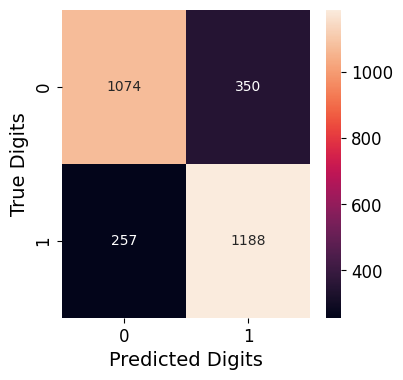

In [38]:
Ada_acc=ada_clf.score(X_test, y_test)
print("Voting accuracy is: {0:.3f}%".format(Ada_acc * 100))
cm_ada = confusion_matrix(y_test, y_pred_ada)
plt.figure(figsize=(4, 4))
sns.heatmap(cm_ada, annot=True, fmt='.0f')
plt.xlabel("Predicted Digits")
plt.ylabel("True Digits")
plt.show()

##Gradient Boosting

In [39]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=300, stop=500, num=1)]
# Learning rate in AdaBoost
learning_rate = [(0.97 + x / 100) for x in range(0, 8)]
max_depth = [int(x) for x in np.linspace(10, 110, num=1)]
max_depth.append(None)

grad = GradientBoostingClassifier(random_state=42)

parameters = {
    'n_estimators': n_estimators,
    'learning_rate': learning_rate,
    'max_depth': max_depth
}
grad_grid = GridSearchCV(grad, parameters,scoring="accuracy", cv=5, verbose=1, n_jobs=-1)
grad_grid.fit(X_train, y_train)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.97, 0.98, 0.99, 1.0, 1.01, 1.02,
                                           1.03, 1.04],
                         'max_depth': [10, None], 'n_estimators': [300]},
             scoring='accuracy', verbose=1)

In [40]:
grad_grid.best_params_

{'learning_rate': 0.97, 'max_depth': 10, 'n_estimators': 300}

In [44]:
#Solo una prova
grad_clf = GradientBoostingClassifier(n_estimators=300, learning_rate=0.97,
                                 max_depth=10, random_state=42)
grad_clf.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.97, max_depth=10, n_estimators=300,
                           random_state=42)

In [45]:

y_pred_grad=model_performance(grad_clf, X_test, y_test)

#len(grad_v)

Balanced Accuracy: 0.801
AUC: 0.801
F1 scroe overall: 0.801
log_loss:7.1736


Voting accuracy is: 80.098%


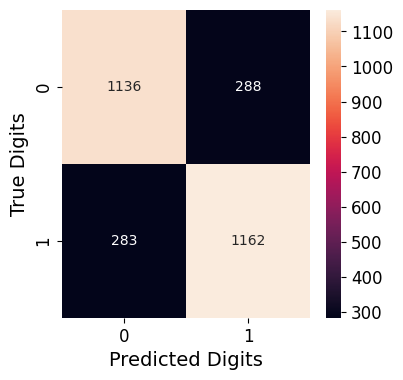

In [46]:
Grad_acc=grad_clf.score(X_test, y_test)
print("Voting accuracy is: {0:.3f}%".format(Grad_acc * 100))
cm_grad = confusion_matrix(y_test, y_pred_grad)
plt.figure(figsize=(4, 4))
sns.heatmap(cm_grad, annot=True, fmt='.0f')
plt.xlabel("Predicted Digits")
plt.ylabel("True Digits")
plt.show()

##XGBoost

https://www.kaggle.com/code/stuarthallows/using-xgboost-with-scikit-learn/notebook

In [47]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=300, stop=500, num=1)]
# Learning rate in AdaBoost
learning_rate = [(0.97 + x / 100) for x in range(0, 8)]
max_depth = [int(x) for x in np.linspace(10, 110, num=1)]
max_depth.append(None)

xgb_clf = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

parameters = {
    "learning_rate": learning_rate,
    "max_depth": max_depth, # default 3
    "n_estimators": n_estimators
}
xgb_grid=GridSearchCV(xgb_clf, parameters,scoring="accuracy", cv=5, verbose=1, n_jobs=-1)
xgb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.97, 0.98, 0.99, 1.0, 1.01, 1.02,
                                           1.03, 1.04],
                         'max_depth': [10, None], 'n_estimators': [300]},
             scoring='accuracy', verbose=1)

In [48]:
xgb_grid.best_params_

{'learning_rate': 1.0, 'max_depth': 10, 'n_estimators': 300}

In [52]:
#Solo una prova
xgb_model = xgb.XGBClassifier(learning_rate=1.0, max_depth=10, n_estimators=300, objective="binary:logistic", random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1.0, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [53]:
y_pred_xgb = model_performance(xgb_model, X_test, y_test)

Balanced Accuracy: 0.7947
AUC: 0.7947
F1 scroe overall: 0.7947
log_loss:7.3997


Voting accuracy is: 79.470%


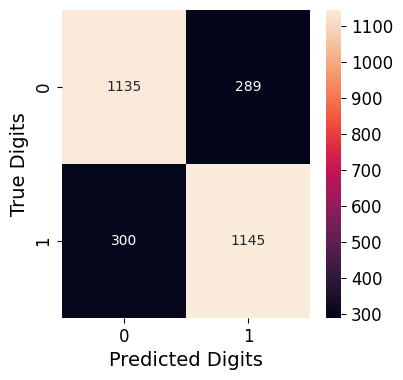

In [54]:
xgb_acc=xgb_model.score(X_test, y_test)
print("Voting accuracy is: {0:.3f}%".format(xgb_acc * 100))
xgb_grad = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(4, 4))
sns.heatmap(xgb_grad, annot=True, fmt='.0f')
plt.xlabel("Predicted Digits")
plt.ylabel("True Digits")
plt.show()